<h1><center>Physique numérique (PHY-3500) - TP3</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [1]:
import numpy as np
import astropy.units as u
from IPython.display import HTML
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from astropy import constants as cte
from matplotlib.animation import FuncAnimation


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Mécanique céleste - la Terre

A) *Utilisez la méthode de Verlet pour calculer l’orbite de la Terre autour du soleil, considérant que le mouvement est décrit par*
$$\frac{d^2\mathbf{r}}{dt^2}=-\frac{GM}{r^3}\mathbf{r}$$

*et sachant que la distance du périhélie est de $1.4710\cdot 10^{11}$ m et que la vitesse tangentielle à cette position est de $3.0287\cdot 104$ m/s (utilisez le module astropy pour les autres constantes nécessaires). Utilisez un incrément temporel $h = 1$ heure. Représentez graphiquement plusieurs orbites, qui devraient appaître légèrement non-circulaires.*
<br><br>
L'équation du mouvement orbital est basée sur la seconde loi de Newton pour le mouvement et la loi universelle de la gravitation de Newton. La seconde loi de Newton stipule que la force nette agissant sur un objet est :
$$\mathbf{F} = m\mathbf{a} \ .$$
De l'autre côté, la loi de la gravitation universelle de Newton dit que :
$$\mathbf{F} = -\frac{GMm}{|\mathbf{r}|^2}\mathbf{\hat{r}} \ ,​​$$
où $G$ est la constante gravitationnelle universelle, $M$ est la masse de l'objet central produisant le champ gravitationnel et $m$ est la masse de l'objet accéléré. Lorsque nous combinons ces deux lois pour calculer l'accélération d'un objet due à la gravité d'un autre objet, la masse de l'objet accéléré (La masse de la Terre dans le cas de l'accélération due au Soleil par exemple) se simplifie des deux côtés de l'équation, nous laissant avec :
$$\mathbf{a} = \frac{\mathbf{F}}{m} = -\frac{GM}{|\mathbf{r}|^2} \ .$$
Pour exprimer cette accélération en termes du vecteur position $\mathbf{r}$ plutôt qu'en termes du vecteur unitaire $\mathbf{\hat{r}}$, on utilise le fait que $\mathbf{\hat{r}}=\frac{\mathbf{r}}{|\mathbf{r}|}$, i.e
$$\mathbf{a} = -\frac{GM}{|\mathbf{r}|^2}\frac{\mathbf{r}}{|\mathbf{r}|} = -\frac{GM}{|\mathbf{r}|^3} \ .$$
Puisque, dans le cas présent, l'objet central est le Soleil, on obtient :
$$\mathbf{a} = -\frac{GM_{sun}}{|\mathbf{r}|^3} \ .$$
On peut conclure de l'équation précédente que l'accélération de l'objet est indépendante de sa masse dans ce modèle.

In [2]:
M_earth = cte.M_earth.value
GM = cte.G.value * cte.M_sun.value


def acceleration(vec: NDArray, dydt: bool = False, d: int = 2) -> NDArray:
    """Calcule l'accélération gravitationnelle à une position donnée.

    Paramètres
    ----------
        vec
            Vecteur d'état ou de la position.
        dydt
            Retourne la dérivée du vecteur d'état 'vec', soit (dr/dt, dv/dt)
            plutôt que l'accélération si True.
        d
            Nombre de dimension des vecteurs dans le vecteur d'état initial.
            Par défaut : 2 pour 2D. Nécessaire seulement si le paramètre
            'dydt' est True.

    Retourne
    --------
        a
            Vecteur de l'acclélération si 'dydt' est False.
        va
            Le vecteur d'état de la vitesse et de l'accélération
            du corps si 'dydt' est True.

    """
    if dydt is True:
        r, v = vec[:d], vec[d:]
        a = -GM * r / np.linalg.norm(r)**3
        va = np.concatenate((v, a))
        return va

    # Dans ce cas, vec est un vecteur de position seulement
    a = -GM * vec / np.linalg.norm(vec)**3
    return a


def rk(r: NDArray, v: NDArray, dt: int, d: int, ord: int) -> NDArray:
    """Effectue un pas de temps en utilisant la méthode de Runge-Kutta.

    Paramètres
    ----------
        r
            Coordonnées de la position en 2D.
        v
            Vecteur de la vitesse.
        dt
            Pas de temps.
        d
            Nombre de dimension des vecteurs.
        ord
            Ordre de la méthode de Runge-Kutta.

    Retourne
    --------
        rv
            Vecteur d'état après l'incrément de temps.

    Soulève
    -------
        ValueError
            Si l'ordre spécifié est ni 2 ni 4.

    """
    # Coefficients a et b de Runge-Kutta d'ordre 1, 2 et 4
    if ord == 1:
        a = np.asarray((0,))
        b = np.asarray((1,))
    elif ord == 2:
        a = np.asarray((0, 1))
        b = np.asarray((0.5, 0.5))
    elif ord == 4:
        a = np.asarray((0, 0.5, 0.5, 1))
        b = np.asarray((1/6, 1/3, 1/3, 1/6))
    else:
        raise ValueError("Seul les ordres 1, 2 et 4 sont supportés")

    k = np.zeros((ord, r.size))
    for n, ak in enumerate(a):
        k[n] = dt * (v + ak * dt * acceleration(r + ak * k[n - 1]))

    r2 = r + b @ k
    v2 = v + dt * acceleration(r2)
    rv = np.concatenate((r2, v2))
    return rv


def orbite(
    y: NDArray,
    h: int,
    t: int,
    d: int = 2,
    algo: str = "verlet",
    eng: bool = False,
) -> NDArray:
    """Calcul une orbite autour du Soleil par la méthode choisie.

    Paramètres
    ----------
        y
            Vecteur d'état initial.
        h
            Pas de temps en secondes.
        t
            Tableau des données temporelles.
        d
            Nombre de dimension des vecteurs.
        algo
            Méthode numérique à utiliser pour le calcul des vecteurs d'état.
        eng
            Si True, retourne également l'énergie potentielle, cinétique et
            totale en tout point.

    Retourne
    --------
        r
            Les positions, en m, à chaque pas de temps.
        v
            Les vitesses, en m/s, à chaque pas de temps.
        U
            L'énergie potentielle, en J, à chaque pas de temps si eng est True.
        K
            L'énergie cinétique, en J, à chaque pas de temps si eng est True.
        E
            L'énergie totale, en J, à chaque pas de temps si eng est True.

    """
    # Travailler sur une copie par sécurité
    state = y.copy()

    for i in range(t.size - 1):
        ri, vi = state[i, :d], state[i, d:]
        a = acceleration(ri, d)

        # Nouvelle position et vitesse en fonction de la méthode choisie
        if algo == "verlet":
            r2 = ri + vi * h + 0.5 * a * h**2
            a2 = acceleration(r2)
            v2 = vi + 0.5 * (a + a2) * h
            rv = np.concatenate((r2, v2))
        elif algo in ("euler", "rk1"):
            rv = rk(ri, vi, h, d, 1)
        elif algo == "rk2":
            rv = rk(ri, vi, h, d, 2)
        elif algo == "rk4":
            rv = rk(ri, vi, h, d, 4)
        else:
            raise ValueError(
            "Seules les méthodes de Verlet, Euler et Runge-Kutta sont supportées."
        )

        state[i + 1] = rv

    r, v = state[:, :d], state[:, d:]
    if eng is True:
        U = -GM * M_earth / np.linalg.norm(r, axis=1)
        K = 0.5 * M_earth * np.linalg.norm(v, axis=1)**2
        E = U + K
        return r, v, U, K, E
    return r, v

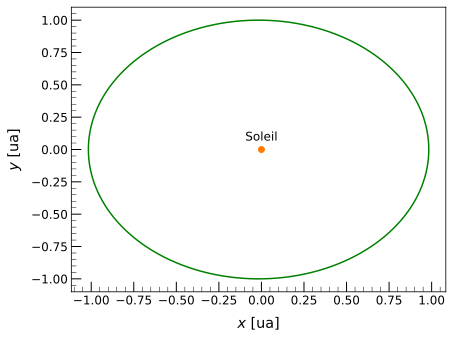

In [3]:
# Conditions initiales
rp = 1.4710e11          # Distance du périhélie en m
vp = 3.0287e4           # Vitesse tangentielle au périhélie en m/s
t0 = 0
tf = 31557600           # Temps final (1 an en s)
h = 3600                # Pas de temps (1 heure en s)

# Génération des données temporelles en jours
time = np.arange(t0, tf, h) * u.s.to("day")

# Vecteur d'état initial [x, y, vx, vy]
y = np.empty((time.size, 4))
y[0, :] = np.asarray((rp, 0, 0, vp))

ver_data = orbite(y, h, time, algo="verlet", eng=True)

# Convertir les positions en ua pour le graphique
r_au_ver = ver_data[0] * u.m.to("au")

plt.plot(r_au_ver[:, 0], r_au_ver[:, 1], "g")
plt.scatter(0, 0, c="#FF7C00")
plt.xlabel("$x$ [ua]")
plt.ylabel("$y$ [ua]")
plt.text(
    0,
    0.05,
    "Soleil",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
)
plt.xlabel("$x$ [ua]")
plt.ylabel("$y$ [ua]")
plt.show()

B) *Modifier votre programme pour qu’il calcule aussi l’énergie potentielle $−\frac{GMm}{r}$ et cinétique $\frac{mv}{2}$ à chaque pas, ainsi que la somme (énergie totale) de ces deux quantités. Rapportez ces valeurs en fonction du temps dans un graphique et commentez.*

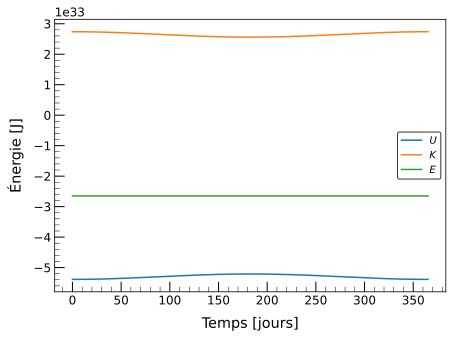

In [4]:
U_ver, K_ver, E_ver = ver_data[2:]

plt.plot(time, U_ver, label="$U$")
plt.plot(time, K_ver, label="$K$")
plt.plot(time, E_ver, label="$E$")
plt.xlabel("Temps [jours]")
plt.ylabel("Énergie [J]")
plt.legend()
plt.show()

Le graphique montre l'évolution de l'énergie potentielle $U$, de l'énergie cinétique $K$, et de l'énergie totale $E$ de la Terre autour du Soleil en fonction du temps, mesuré en jours, sur une période d'un an. Comme attendu pour un système conservatif, L'énergie potentielle varie de manière inversée par rapport à l'énergie cinétique : lorsque la Terre s'approche du Soleil (diminution de la distance $r$), l'énergie potentielle devient plus négative tandis que l'énergie cinétique augmente, et vice versa. L'énergie totale demeure constante dans le temps, comme attendu par conservation de l'énergie dans le système Terre-Soleil. Cela montre également que la méthode de Verlet est une méthode numérique adéquate pour ce type de problème.

C) *Utilisez maintenant la méthode d’Euler, RK2 et RK4 pour calculer l’orbite de la Terre et l’énergie totale en fonction du temps, que vous rapportez sur le même graphique que l’énergie totale en fonction du temps calculée par la méthode de Verlet. Votre graphique devrait montrer le caractère symplectique de la méthode de Verlet vs Euler/RK2/RK4.*
<br>

#### **Méthode d'Euler**

La méthode d'Euler est une approche de premier ordre pour résoudre des équations différentielles du premier ordre de la forme $\frac{dy}{dt} = f(t,\ y)$. La formule générale de cette méthode est :
$$y_{n+1} = y_n + hf(t_n,\ y_n) \ ,$$
où $y_n$ est l'approximation de $y$ à l'instant $t_n$, $h$ est le pas de temps, et $f(t_n,\ y_n)$ est la valeur de la dérivée de $y$ au point $(t_n,\ y_n)$. Alternativement, la méthode d'Euler peux être écrite sous la forme d'une méthode de Runge-Kutta d'ordre 1, i.e
\begin{align*}
    k_1 &= f(t_n,\ y_n) \\
    y_{n+1} &= y_n + hk_1 \ .
\end{align*}

#### **Méthode de Runge-Kutta d'ordre 2 (RK2)**

La méthode RK2, ou Runge-Kutta d'ordre 2, offre une meilleure précision que la méthode d'Euler en prenant une "moyenne pondérée" des pentes. Une forme courante de RK2 est la méthode du point milieu. L'approche RK2 s'exprime :
\begin{align*}
    k_1 &= f(t_n,\ y_n) \\
    k_2 &= f(t_n + \frac{h}{2},\ y_n + \frac{h}{2}k_1) \\
    y_{n+1} &= y_n + hk_2 \ ,
\end{align*}

où, $k_1$​ et $k_2$ sont des estimations intermédiaires de la pente.

#### **Méthode de Runge-Kutta d'ordre 4 (RK4)**

La méthode RK4 est une méthode de Runge-Kutta réputée pour sa grande précision. Elle calcule quatre pentes intermédiaires pour estimer la pente moyenne la plus précise.
\begin{align*}
    k_1 &= f(t_n,\ y_n) \\
    k_2 &= f(t_n + \frac{h}{2},\ y_n + \frac{h}{2}k_1) \\
    k_3 &= f(t_n + \frac{h}{2},\ y_n + \frac{h}{2}k_2) \\
    k_4 &= f(t_n + h,\ y_n + hk_3) \\
    y_{n+1} &= y_n + \frac{h}{6} (k_1 + 2k_2 + 2k_3 + k_4) \ ,
\end{align*}

où $k_1$, $k_2$, $k_3$ et $k_4$​ sont les estimations des pentes utilisées pour calculer $y_{n+1}​$. Ces formules fournissent une excellente base pour l'implémentation numérique des solutions d'équations différentielles ordinaires.

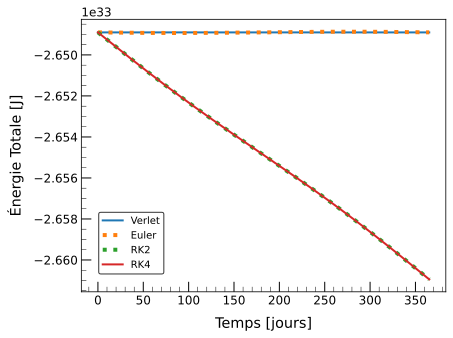

In [5]:
E_euler = orbite(y, h, time, algo="euler", eng=True)[-1]
E_rk2 = orbite(y, h, time, algo="rk2", eng=True)[-1]
E_rk4 = orbite(y, h, time, algo="rk4", eng=True)[-1]

plt.plot(time, E_ver, lw=2, label="Verlet")
plt.plot(time, E_euler, lw=4, ls=":", label="Euler")
plt.plot(time, E_rk2, lw=4, ls=":", label="RK2")
plt.plot(time, E_rk4, lw=2, label="RK4")
plt.xlabel("Temps [jours]")
plt.ylabel("Énergie Totale [J]")
plt.legend(bbox_to_anchor=(0.24, 0.31))
plt.show()

Le graphique compare l’énergie totale de la Terre autour du Soleil calculé par la méthode de Verlet et par la méthode de Runge-Kutta d’ordre 2 et 4 au cours d’une année, avec un pas de temps d’une heure. Physiquement, l’énergie totale du système devrait demeurer constante dans le temps, malgré les fluctuations de l’énergie potentielle et cinétique, en vertu de la loi de la conservation de l’énergie. Le graphique montre qu’avec les méthodes Euler, RK2 et RK4, l’énergie totale $E$ n’est pas conservée au fil du temps. Cependant, la méthode de Verlet produit des valeurs de $E$ constantes dans le temps, témoignant ainsi du caractère symplectique de la méthode de Verlet.

D) Utilisez maintenant la méthode de Bulirsch-Stoer pour calculer l’orbite de la Terre, avec une précision de 1 km par année (voir l’exemple 8.7 dans le Newman pour une implémentation, que vous pouvez réutiliser). Utilisez un intervalle $h$ de une semaine. Comparez avec la précision obtenue avec les autres méthodes.

In [6]:
GM = cte.G.value * cte.M_sun.value


def bulirsch_stoer(
    state: NDArray,
    t0: int | float,
    tf: int | float,
    H: int | float,
    tol: int | float,
    d: int = 3,
    eng: bool = False,
) -> NDArray:
    y = state.copy()

    # Génération des données temporelles en secondes
    # On ajoute un pas de H pour inclure tf
    tpts = np.arange(t0, tf + H, H, dtype=float)

    # solutions = np.empty((tpts.size, y.size))
    solutions = []

    for i, _ in enumerate(tpts):
        n = 1
        # solutions[i] = y
        solutions.append(y)

        # Premier pas avec la méthode du point milieur modifiée
        r1 = y + 0.5 * H * acceleration(y, True, d)
        r2 = y + H * acceleration(r1, True, d)
        R1 = np.empty((1, y.size))
        R1[0] = 0.5 * (r1 + r2 + 0.5 * H * acceleration(r2, True, d))

        error = np.inf
        while error > H * tol:
            n += 1
            h = H / n

            # On rafine l'estimation avec la méthode du point milieu modifiée
            r1 = y + 0.5 * h * acceleration(y, True, d)
            r2 = y + h * acceleration(r1, True, d)
            for _ in range(n - 1):
                r1 += h * acceleration(r2, True, d)
                r2 += h * acceleration(r1, True, d)

            # Extrapolation de Richardson
            R2 = R1
            R1 = np.empty((n, y.size))
            R1[0] = 0.5 * (r1 + r2 + 0.5 * h * acceleration(r2, True, d))
            for m in range(1, n):
                epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
                R1[m] = R1[m - 1] + epsilon

            # Calcul de l'erreur sur la position
            error = np.linalg.norm(epsilon[:d])

        # Conserve la meilleure estimation avant le pas suivant
        y = R1[n - 1]

    # Créer un tableau de l'énergie potentielle, cinétique et totale
    solutions = np.asarray(solutions)
    if eng is True:
        r, v = solutions[:, :d], solutions[:, d:]
        UKE = np.empty((len(solutions), 3))
        UKE[:, 0] = -GM * M_earth / np.linalg.norm(r, axis=1)
        UKE[:, 1] = 0.5 * M_earth * np.linalg.norm(v, axis=1)**2
        UKE[:, 2] = UKE[:, :2].sum(axis=1)
        return tpts, solutions, UKE
    return tpts, solutions

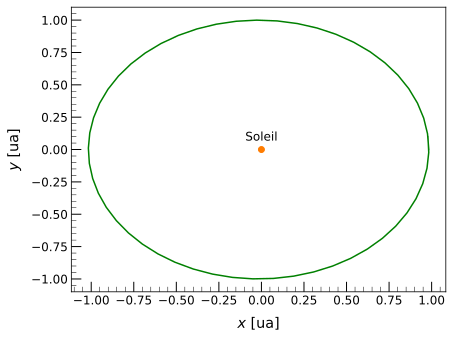

In [7]:
# Conditions initiales
t0 = 0
tf = u.year.to("s")
dt = u.week.to("s")

# Convertir la tolérance souhaitée en unités SI MKS
tol = u.km / u.year
tol = tol.to("m / s")

t_bul, sol, E_bul = bulirsch_stoer(y[0], t0, tf, dt, tol, d=2, eng=True)

# Visualiser les graphiques d'énergie en jours
t_bul *= u.s.to("day")

# Convertir les m en untité astronomique pour le graphique
pos_au = sol[:, :2] * u.m.to("au")

plt.plot(pos_au[:, 0], pos_au[:, 1], "g", label="Orbite terrestre")
plt.scatter(0, 0, c="#FF7C00")
plt.xlabel("$x$ [ua]")
plt.ylabel("$y$ [ua]")
plt.text(
    0,
    0.05,
    "Soleil",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
)
plt.show()

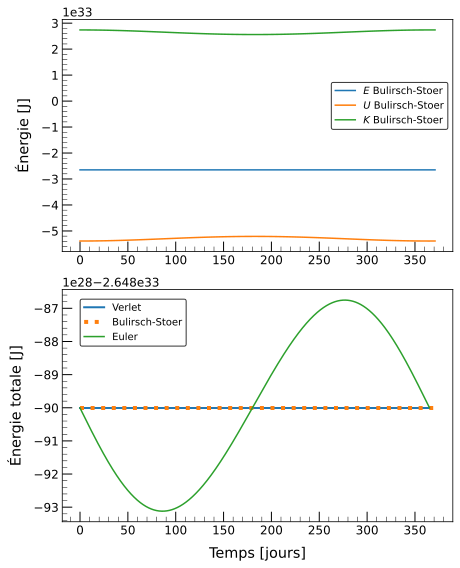

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5, 8))
ax1.plot(t_bul, E_bul[:, -1], label="$E$ Bulirsch-Stoer")
ax1.plot(t_bul, E_bul[:, 0], label="$U$ Bulirsch-Stoer")
ax1.plot(t_bul, E_bul[:, 1], label="$K$ Bulirsch-Stoer")
ax1.set_ylabel("Énergie [J]")
ax1.legend(bbox_to_anchor=(1, 0.75))

ax2.plot(time, E_ver, lw=2, label="Verlet")
ax2.plot(t_bul, E_bul[:, -1], lw=4, ls=":", label="Bulirsch-Stoer")
ax2.plot(time, E_euler, label="Euler")
ax2.set_xlabel("Temps [jours]")
ax2.set_ylabel("Énergie totale [J]")

ax2.legend(bbox_to_anchor=(0.33, 0.98))
plt.show()

Le graphique ci-dessus compare la méthode de Bulirsch-Stoer aux méthodes de Verlet et d’Euler. Comme il a été démontré plus tôt que RK2 et RK4 ne donnent pas les résultats attendus d’un système conservatif, ils ont été retirés du graphique pour mieux situer Bulirsch-Stoer par rapport à Verlet, la meilleure méthode utilisée dans cette simulation. Les résultats obtenus par la méthode de Bulirsch-Stoer avec une tolérance de 1 km par année montrent un caractère symplectique, similairement à la méthode de Verlet. En effet, ces deux algorithmes permettent de conserver l’énergie totale sur toute la durée de la simulation. D’autre part, l’énergie calculée avec la méthode d’Euler oscille dans le temps, ce qui implique que l’énergie n’est pas conservée.

# Mécanique céleste - Mars

E) *Utilisez Bulirsch-Stoer pour calculer la position de Mars 203 jours plus tard, soit le 18 février 2021 (jour de l’atterrissage). Ne lésinez pas sur la précision, ca coûte cher un astromobile. Notez que les calculs seront effectués en trois dimensions. Comparez votre position calculée à la valeur de l’éphéméride, soit eph.position("mars", atterissage.jd). Commentez, notamment sur vos limites et celles de la méthode utilisée.*

In [9]:
import de421
import astropy.units as u
from astropy.time import Time
from jplephem import Ephemeris
from plotly import graph_objects as go


# Convertir les unités de G pour correspondre à l'éphémérie
G = cte.G.to("km3 / (kg day2)").value
GM = G * cte.M_sun.value

# Dates et données initiales
eph = Ephemeris(de421)
lancement = Time("2020-07-30").jd
atterissage = Time("2021-02-18").jd
pos, vel = eph.position_and_velocity("mars", lancement)

# Données de référence
t = np.linspace(lancement, atterissage, 1000)
ref_data = eph.position("mars", t).T * u.km
ref_data_au = ref_data.to("au")

# Vecteur d'état initial
y0_mars = np.empty(6)
y0_mars[:3] = pos.T[0]
y0_mars[3:] = vel.T[0]

# Conditions initiales
t0 = 0
tf = 203
dt = 1      # Pas de temps (1 jour)

# Convertir la tolérance souhaitée (1 km / année) en km / jours
tol = u.km / u.year
tol = tol.to("km / day")

time, mars = bulirsch_stoer(y0_mars, t0, tf, dt, tol, d=3)

# Convertir les km en ua pour diminuer l'échelle des nombres
ref_au = ref_data_au[-1]
pos_mars = mars[:, :3] * u.km
pos_mars_au = pos_mars.to("au")

# Calcul de l'écart par rapport à la référence
drift = np.linalg.norm(pos_mars[-1] - ref_data[-1])
drift_au = drift.to("au")

print(f"Position finale simulée : {pos_mars_au[-1]}")
print(f"Position finale de référence : {ref_au}\n")
print(f"Écart entre la position finale simulée et la position de référence :")
print(f"{drift:.3e} ou {drift_au:.3e}")

Position finale simulée : [-0.03661364  1.40919144  0.64748039] AU
Position finale de référence : [-0.0130041   1.43237611  0.65715551] AU

Écart entre la position finale simulée et la position de référence :
5.157e+06 km ou 3.448e-02 AU


In [10]:
fig = go.Figure()

# Ajouter la trajectoire simulée
fig.add_trace(
    go.Scatter3d(
        x=pos_mars_au[:, 0],
        y=pos_mars_au[:, 1],
        z=pos_mars_au[:, 2],
        mode="lines",
        name="Orbite simulée",
        line=dict(width=4, color="brown")
    )
)

# Ajouter la trajectoire de référence
fig.add_trace(
    go.Scatter3d(
        x=ref_data_au[:, 0],
        y=ref_data_au[:, 1],
        z=ref_data_au[:, 2],
        mode="lines",
        name="Orbite de référence",
        line=dict(width=4, color="green", dash="dash")
    )
)

# Ajouter le Soleil au centre
fig.add_trace(
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode="markers",
        name="Barycentre du système",
        marker=dict(size=10, color='#FF7C00'),
    )
)

fig.update_layout(
    title="Orbite de Mars autour du Soleil",
    paper_bgcolor="black",
    font_color="white",
    scene=dict(
        xaxis=dict(title="x [ua]"),
        yaxis=dict(title="y [ua]"),
        zaxis=dict(title="z [ua]"),
    ),
    width=800,
    height=700,
)

fig.show()

F) *Quelle méthode numérique la NASA utilise-t-elle pour envoyer des sondes vers Mars ?*

La NASA utilise une variété d'algorithmes numériques et d'outils pour les calculs de trajectoire pour des missions telles que l'envoi de sondes sur Mars. Pour l'intégration numérique qui calcule la trajectoire de l'engin spatial, la NASA utilise des méthodes adaptatives comme la méthode Runge-Kutta-Fehlberg (RKF78), une variante spécifique de la méthode de Runge-Kutta. Cette méthode fait partie d'une famille d'intégrateurs à pas adaptatif qui aident à obtenir une grande précision dans les simulations de trajectoire tout en minimisant l'effort de calcul. Le RKF78 utilise spécifiquement une formule de Runge-Kutta d'ordre sept pour l'intégration avec un estimateur d'erreur d'ordre huit pour contrôler la taille du pas. [1] Un algorithme notable également utilisée est la méthode de correction différentielle, notamment à travers des outils comme "GMAT" de la NASA (General Mission Analysis Tool). La correction différentielle est utilisée pour affiner les conceptions de trajectoire, en veillant à ce que l'engin spatial suive le chemin prévu aussi étroitement que possible en ajustant de manière itérative une estimation jusqu'à ce que les conditions orbitales souhaitées soient satisfaites. [2]

G) Cette méthode est-elle en cause dans la perte du Mars Climate Orbiter en 1999 ? Si non, quelle a été la cause de cette perte ?
<br><br>
Non, la perte du Mars Climate Orbiter n'est pas due directement à la méthode numérique utilisée pour calculer sa trajectoire, mais plutôt à une erreur de communication entre les équipes. Un groupe utilisait le système métrique, tandis que l'autre utilisait le système impérial. Cette incohérence dans les unités de mesure a conduit à une erreur dans la trajectoire de la sonde, la faisant entrer dans l'atmosphère martienne à une altitude plus basse que prévu, ce qui a résulté en sa destruction. [3]

# L’équation de Schrödinger et la méthode spectrale

H) Ecrivez un programme pour calculer les valeurs des coefficients $\beta_k$, qui peuvent de façon pratique être séparés en composantes réelles et imaginaires ($\beta_k = \alpha_k + i\eta_k$). Divisez la boÎte en N = 1000 tranches et créez deux conteneurs pour les parties rélles et imaginaires de $\psi(x_n, 0)$ à chaque point de la grille. Effectuez une transformée en sinus pour chaque conteneur séparément, i.e. calculez les valeurs de $\alpha_k$ et $\beta_k$ pour $k = 1...N − 1$. Vous utiliserez les fonctions du module dcst de Newman (Appendix E ou son site web).

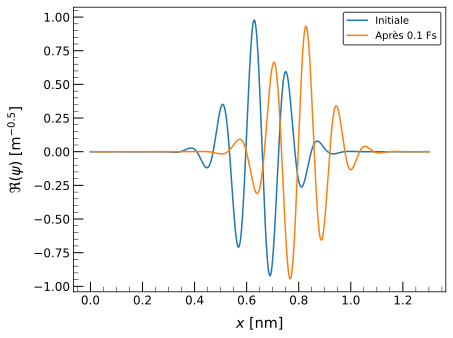

In [11]:
# Paramètres
L = 1.3e-9
k = np.arange(1000)

# Grille spatiale
x = np.linspace(0, L, 1000)

# Condition initiale
x0 = L / 2
sigma = 1e-10
kappa = 5e10
psi_x0 = np.exp(-((x - x0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * kappa * x)

# Calcul des coefficients bk par DFT
bk = np.fft.fft(psi_x0)

# Évolution temporelle
t = 1e-16
E = np.pi**2 * cte.hbar**2 * k**2 / (2 * cte.m_e * L**2)


def psi(t):
    psi_xt = np.fft.ifft(bk * np.exp(-1j * E.value * t / cte.hbar.value)).real
    return psi_xt


psi_xt = psi(t)

# Tracé de la partie réelle de la fonction d'onde
plt.plot(x * 1e9, psi_x0.real, label="Initiale")
plt.plot(x * 1e9, psi_xt, label=f"Après {t * 1e15:.1f} Fs")
plt.xlabel("$x$ [nm]")
plt.ylabel("$\\Re(\\psi)$ [m$^{-0.5}$]")
plt.legend()
plt.show()

J) *Expliquez pourquoi Newman s’en remet à la fonction rfft de numpy pour calculer la transformée en sinus.*

La fonction rfft de NumPy est utilisée pour effectuer une Transformée de Fourier Rapide (FFT) sur des données réelles. La fonction ``rfft`` est optimisée pour les données réelles et utilise moins de calcul que la FFT complète, car elle n'a pas besoin de traiter la partie imaginaire symétrique des données, ce qui est le cas dans les signaux réels. Bien que l'équation de Schrödinger et certaines autres applications physiques nécessitent des calculs en termes de transformées de Fourier sinus et cosinus, il n'existe pas de fonction directe dans NumPy pour effectuer une transformée en sinus ou en cosinus seule. Newman utilise donc ``rfft`` et manipule les résultats pour obtenir une approximation ou un équivalent de la transformée en sinus, adaptant ainsi l'outil disponible à son besoin spécifique.

K) Maintenant que tout est en place, vous pouvez produire une animation de l’évolution de la fonction d’onde (normalisée) au cours du temps, en générant une image à plusieurs t (utilisez un incrément de 10−18 s). Il y a probablement plusieurs façons d’y arriver, l’une d’elle étant le package visual. Prenez soin d’ajuster le taux de rafraîchissement et les échelles pour bien apprécier la dynamique de la fonction d’onde.

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
line, = ax.plot(x / L, psi_x0.real)
ax.set_xlabel("$x / L$", fontsize=15)
ax.set_ylabel("$\\Re(\\psi)$ [$m^{-0.5}$]", fontsize=15)
plt.close()


def animate(i):
    #un pas de dt = 10^-16 s est plus approprié pour voir l'évolution de la fonction d'onde dans le temps
    line.set_ydata(psi(i*1e-16))
    return line,


ani = FuncAnimation(fig, animate, interval=100, blit=True, frames=100)
HTML(ani.to_jshtml())

I) *Laissez tourner votre animation un moment et décrivez ce que vous observez, en utilisant bien entendu un langage se rapportant à la physique du problème.*

# Références

[1] Kaushik Ponnapalli and Robert D Falck. *Obtaining Accurate Derivatives Across Adaptive-Step Integration*. NASA Glenn Research Center, 2023. URL: [Adaptative methods](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://ntrs.nasa.gov/api/citations/20230015848/downloads/Derivatives_AdaptiveStep_Integration.pdf%3Fattachment%3Dtrue&ved=2ahUKEwjHssyw1LuFAxXXEFkFHSDgDlg4ChAWegQIAhAB&usg=AOvVaw0VQwxmM4qLacDGpc8WktdD). Page consultée le 2 avril 2024.
<br>
[2] Steven P. Hughes *et al*. *Verification and Validation of the General Mission Analysis Tool (GMAT)*. NASA Goddard Space Flight Center, 2014. URL: [GMAT](https://ntrs.nasa.gov/api/citations/20140017798/downloads/20140017798.pdf). Page consultée le 2 avril 2024.
<br>
[3] James Oberg. "Why the Mars Probe went off course". *IEE Spectrum* (dec 1999). URL: [Mars Climate Orbiter](https://spectrum.ieee.org/why-the-mars-probe-went-off-course). Page consultée le 9 avril 2024.
<br>